# Part 1

What's the plan?

1 Understand our data better in **Exploratory Data Analysis**, do necessary data wrangling

2 Use sales from Oct 2015 as predictions for Nov 2015(**Previous Value Benchmark**)

3 **Quick Baseline**. Apply some variant of decision tree(without any feature engineering, compare this with previous value benchmark)

4 Set up **Cross Validation** to try out different feature engineering ideas

5 Tune decision tree models, try to tune and get several diverse models with similar performance

6 Use Ensemble methods to boost score
  
Btw, I'll omit the ploting part of EDA and all outputs of my code, because I am just compiling my notebooks and upload to kaggle as a kernel for future reference. But feel free to use my code here to get started and try my feature engineering ideas!

# Exploratory Data Analysis

## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm
from sklearn import preprocessing
from xgboost import plot_tree
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 60)

## Data loading
Load all provided datasets and get a feel of the data provided to us

In [34]:
sales_train = pd.read_csv('D:\\all\\sales_train_v2.csv')
items = pd.read_csv('D:\\all\\items.csv')
shops = pd.read_csv('D:\\all\\shops.csv')
item_categories = pd.read_csv('D:\\all\\item_categories.csv')
test = pd.read_csv('D:\\all\\test.csv')
sample_submission = pd.read_csv('D:\\all\\sample_submission.csv')

In [4]:
sales_train[sales_train.item_price<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [5]:
sales_train[(sales_train.item_id==2973) & (sales_train.shop_id==32) ]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,29.01.2013,0,32,2973,2499.0,1.0
67428,25.01.2013,0,32,2973,2499.0,1.0
67429,22.01.2013,0,32,2973,2499.0,1.0
67430,21.01.2013,0,32,2973,2499.0,1.0
67431,18.01.2013,0,32,2973,2499.0,1.0
67432,17.01.2013,0,32,2973,2499.0,1.0
67433,15.01.2013,0,32,2973,2499.0,3.0
187844,05.02.2013,1,32,2973,2499.0,1.0
187845,14.02.2013,1,32,2973,2499.0,1.0
484682,23.05.2013,4,32,2973,1249.0,1.0


In [6]:
# correct negative price with the most frequent
sales_train.at[484683,"item_price"]=2499.0

In [7]:
#correct sales in 10th shop in 25 period - copy from 11th
sales_train.pivot_table(index="date_block_num", columns="shop_id", values="item_cnt_day", aggfunc="sum" )

shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
date_block_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5578.0,2947.0,1146.0,767.0,2114.0,NaN,3686.0,2495.0,1463.0,NaN,935.0,NaN,842.0,1178.0,1777.0,2724.0,2978.0,NaN,2856.0,3038.0,NaN,1495.0,1924.0,1948.0,1768.0,8215.0,2331.0,5548.0,7057.0,2820.0,2978.0,10173.0,1238.0,NaN,NaN,2127.0,NaN,2399.0,1704.0,NaN,NaN,1998.0,3991.0,1759.0,1708.0,1634.0,3363.0,2115.0,NaN,NaN,3406.0,2748.0,1812.0,2055.0,9386.0,NaN,3238.0,NaN,NaN,2017.0
1,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,NaN,1026.0,NaN,1209.0,1036.0,1795.0,2746.0,2614.0,NaN,3341.0,2834.0,NaN,1854.0,2447.0,1941.0,1782.0,7934.0,2597.0,4546.0,5438.0,2834.0,2717.0,11160.0,1494.0,NaN,NaN,2205.0,NaN,2216.0,1670.0,NaN,NaN,1856.0,3965.0,2033.0,1823.0,1530.0,2660.0,1824.0,NaN,NaN,3054.0,2284.0,1737.0,1906.0,8075.0,NaN,2655.0,NaN,NaN,1897.0
2,NaN,NaN,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,NaN,1017.0,NaN,1419.0,1245.0,1893.0,2835.0,3088.0,NaN,3551.0,3020.0,NaN,2233.0,2588.0,2118.0,2014.0,9732.0,3036.0,5454.0,6918.0,3151.0,3026.0,12670.0,1890.0,NaN,NaN,2568.0,NaN,2629.0,2009.0,NaN,NaN,1816.0,4953.0,2504.0,2131.0,1883.0,3103.0,1977.0,NaN,NaN,3610.0,2605.0,2034.0,2365.0,9488.0,NaN,3099.0,6586.0,3773.0,2028.0
3,NaN,NaN,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,NaN,756.0,NaN,1364.0,1018.0,1247.0,2168.0,2118.0,NaN,2421.0,2291.0,NaN,1846.0,2297.0,1698.0,787.0,7867.0,2381.0,3946.0,4910.0,2252.0,2379.0,9621.0,1364.0,NaN,NaN,1845.0,NaN,1946.0,1375.0,NaN,NaN,1387.0,3978.0,1880.0,1628.0,1253.0,2160.0,1540.0,NaN,NaN,2740.0,1945.0,1446.0,1515.0,6726.0,NaN,2153.0,5493.0,2831.0,1388.0
4,NaN,NaN,553.0,710.0,1211.0,1110.0,3022.0,1647.0,NaN,NaN,683.0,NaN,917.0,1104.0,1489.0,1931.0,2261.0,NaN,2944.0,2089.0,NaN,1646.0,1755.0,NaN,1967.0,6860.0,2148.0,3518.0,5703.0,2345.0,2304.0,9423.0,1209.0,NaN,NaN,2048.0,NaN,2019.0,1337.0,NaN,NaN,1597.0,3594.0,1624.0,1379.0,1333.0,2522.0,1724.0,NaN,NaN,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0
5,NaN,NaN,832.0,784.0,1464.0,1393.0,3847.0,2085.0,NaN,NaN,764.0,NaN,1710.0,1358.0,1863.0,2419.0,3075.0,906.0,3144.0,2638.0,NaN,1912.0,2243.0,NaN,2599.0,8478.0,2661.0,275.0,7056.0,2803.0,2794.0,10072.0,1493.0,NaN,NaN,2280.0,NaN,1829.0,1539.0,NaN,NaN,2185.0,4349.0,2060.0,1666.0,1785.0,2865.0,1654.0,NaN,NaN,3761.0,2200.0,1815.0,2125.0,8101.0,728.0,3105.0,5987.0,2972.0,1707.0
6,NaN,NaN,807.0,721.0,1378.0,1265.0,3360.0,2031.0,NaN,NaN,800.0,NaN,723.0,1094.0,1709.0,2599.0,2898.0,1044.0,2676.0,2459.0,NaN,1860.0,1903.0,NaN,2377.0,7361.0,2163.0,4148.0,6739.0,2205.0,2438.0,9500.0,93.0,NaN,NaN,2041.0,NaN,1293.0,1453.0,NaN,NaN,1997.0,3801.0,1632.0,1487.0,1507.0,2966.0,1329.0,NaN,NaN,3235.0,2273.0,1616.0,1975.0,7225.0,795.0,3294.0,5827.0,3122.0,1747.0
7,NaN,NaN,875.0,890.0,1713.0,1510.0,3702.0,2397.0,NaN,NaN,755.0,NaN,1599.0,944.0,2216.0,2536.0,2457.0,1306.0,1778.0,2675.0,NaN,2061.0,2017.0,NaN,2304.0,7784.0,2452.0,4925.0,7521.0,2073.0,2799.0,9882.0,NaN,NaN,NaN,2391.0,NaN,1472.0,1895.0,NaN,NaN,2149.0,4035.0,1849.0,1610.0,1649.0,3315.0,1610.0,NaN,NaN,3718.0,2142.0,1772.0,2367.0,7792.0,719.0,3311.0,5413.0,2863.0,2048.0
8,NaN,NaN,945.0,1026.0,1536.0,1298.0,4208.0,2599.0,NaN,NaN,1027.0,NaN,2032.0,1153.0,796.0,2790.0,1924.0,1459.0,2774.0,2801.0,NaN,2486.0,2518.0,NaN,3072.0,9251.0,3206.0,4981.0,6753.0,2832.0,3023.0,11204.0,NaN,NaN,NaN,2473.0,NaN,1666.0,1666.0,NaN,NaN,2146.0,5093.0,2768.0,1849.0,1725.0,2963.0,1742.0,NaN,NaN,3655.0,1903.0,2125.0,2440.0,7827.0,812.0,2829.0,5213.0,2735.0,2008.0


In [8]:
t2=sales_train[(sales_train["shop_id"]==11) & (sales_train["date_block_num"]==25)]
for i,j in t2.iterrows():
    t2.at[i, "shop_id"]=10
sales_train=pd.concat([sales_train,t2], ignore_index=True)
shops["city"]=shops["shop_name"].map(lambda x: str(x).split()[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [9]:
needed_shops=test["shop_id"].unique()
all_shops=range(0,59)
drop_shops=set(all_shops)-set(needed_shops)

In [10]:
# remove shops which are not asked to predict
indices_remove=[i for i, j in sales_train.iterrows() if j[2] in drop_shops]
sales = sales_train.drop(indices_remove, axis=0)

In [11]:
sales.shape

(2413745, 6)

In [12]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


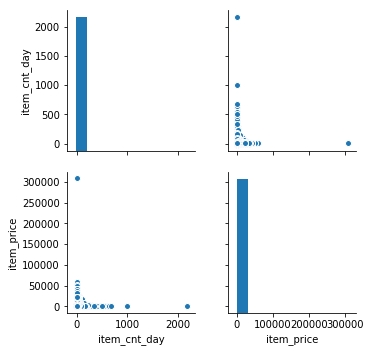

In [209]:
#anomalies

sns.pairplot(sales[["item_cnt_day", "item_price"]].fillna(0))

In [210]:
sales.describe(percentiles=[])

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.413745e+06,2.413745e+06,2.413745e+06,2.413745e+06,2.413745e+06
mean,1.513658e+01,3.227814e+01,1.012336e+04,9.051815e+02,1.239146e+00
std,9.538021e+00,1.641157e+01,6.322122e+03,1.759146e+03,2.731865e+00
min,0.000000e+00,2.000000e+00,1.000000e+00,7.000000e-02,-2.200000e+01
50%,1.400000e+01,3.100000e+01,9.035000e+03,3.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [211]:
sales[sales.item_price>sales.item_price.mean()+20*sales.item_price.std()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
884848,11.09.2013,8,12,2410,36990.0,1.0
885138,17.09.2013,8,12,11365,59200.0,1.0
1006638,24.10.2013,9,12,7238,42000.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1394150,10.02.2014,13,12,5748,36990.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0
1592289,16.04.2014,15,14,5748,36990.0,1.0
1656109,09.05.2014,16,5,5748,36990.0,1.0
2143903,20.11.2014,22,12,14173,40900.0,1.0
2327159,29.01.2015,24,12,7241,49782.0,1.0


In [41]:
sales[sales.item_id==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [163]:
items[items.item_id==6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [13]:
# delete outlier with price
sales.drop(1163158, axis=0, inplace=True)

In [14]:
sales["group"]=sales.item_cnt_day.apply(lambda x: "less 20" if x<20 else "more")

In [15]:
#sales>20 are just 0.127%, thus cut sales tail: make them = 20
sales["group"].value_counts(normalize=True)

less 20    0.998735
more       0.001265
Name: group, dtype: float64

In [16]:
sales.item_cnt_day=sales.item_cnt_day.clip(0,20)

In [17]:
sales.drop("group", axis=1, inplace=True)

C:\Users\KryvalapavaP\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


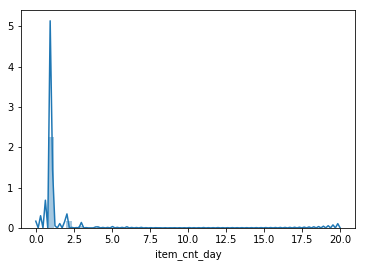

In [21]:
sns.distplot(sales['item_cnt_day'])

In [41]:
#add new feature - city
shops["city"]=shops["shop_name"].map(lambda x: str(x).split()[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [47]:
# add new features: item category & city
#sales=pd.merge(sales, shops[["shop_id", "city"]], how="left", on="shop_id")
#sales=pd.merge(sales, items[["item_id", "item_cat_name_new"]], how="left", on="item_id")
#sales=sales.rename(columns={"item_cat_name_new": "cat_name"})

In [19]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [20]:
sales_train=sales

## Insert missing rows and aggregations

In [21]:
# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32) # vstack to make np array from list

In [22]:
# Aggregations
#sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0,20)
groups = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])
trainset = groups.agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()
trainset = trainset.rename(columns = {'item_cnt_day' : 'item_cnt_month'})
#trainset['item_cnt_month'] = trainset['item_cnt_month'].clip(0,20)

In [23]:
trainset.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,2,27,0,1.0,2499.0
1,2,27,17,1.0,498.0
2,2,30,2,1.0,359.0
3,2,30,5,1.0,399.0
4,2,30,15,1.0,169.0


In [24]:
trainset = pd.merge(grid, trainset, how='left', on=['shop_id', 'item_id', 'date_block_num'])
trainset.item_cnt_month = trainset.item_cnt_month.fillna(0)
trainset.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,NaN
2,59,2554,0,0.0,NaN
3,59,2555,0,0.0,NaN
4,59,2564,0,0.0,NaN


In [25]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [26]:
 # Get category id, name  & city name
trainset = pd.merge(trainset, items[['item_id', 'item_category_id']], on = 'item_id')

trainset.to_csv('trainset_with_grid.csv')
trainset.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,25,22154,0,5.0,999.0,37
2,24,22154,0,1.0,999.0,37
3,19,22154,0,0.0,NaN,37
4,22,22154,0,0.0,NaN,37


# Previous Value Benchmark
**Copy from coursera**  
"
A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference."

** Comments **

Simply put: Use October 2015 sales(number of items sold) as our predictions for sales of November 2015


In [60]:

prev_month_selector = trainset.date_block_num == 33
train_subset = trainset[prev_month_selector]
groups = train_subset[['shop_id', 'item_id', 'item_cnt_month']].groupby(by = ['shop_id', 'item_id'])
train_subset = groups.agg({'item_cnt_month':'sum'}).reset_index()
train_subset.head()

,shop_id,item_id,item_cnt_month
0,2,30,0.0
1,2,31,1.0
2,2,32,0.0
3,2,33,0.0
4,2,40,0.0


In [65]:
merged = test.merge(train_subset, on=["shop_id", "item_id"], how="left")[["ID", "item_cnt_month"]]
merged.isna().sum()
merged.head()

,ID,item_cnt_month
0,0,0.0
1,1,NaN
2,2,1.0
3,3,0.0
4,4,NaN


In [64]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


After merging, we will have lots of missing values of item_cnt_month. This is because we only have so much shop_id/item_id pair from Oct 2015. Fill missing values with 0 and clip values to range (0,20)

In [69]:
merged['item_cnt_month'] = merged.item_cnt_month.fillna(0).clip(0,20)
submission = merged.set_index('ID')
submission.head()
submission.to_csv('benchmark.csv')

# Quick Baseline with XGBoost
Here, I'll use only the following features to make a quick baseline solution for the problem  
  
  **'shop_id', 'item_id', 'item_category_id', 'date_block_num'**  
  
Note that target is **item_cnt_month**

In [108]:

# Extract features and target we want
baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_cnt_month']
train = trainset[baseline_features]
 # Remove pandas index column
train = train.set_index('shop_id')
train.item_cnt_month = train.item_cnt_month.astype(int)
train['item_cnt_month'] = train.item_cnt_month.fillna(0)
    # Save train set to file
train.to_csv('train.csv')


In [109]:
dataset = loadtxt('train.csv', delimiter="," ,skiprows=1, dtype = int)
trainx = dataset[:, 0:4]
trainy = dataset[:, 4]

test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
test_df = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])

    # Make test_dataset pandas data frame, add category id and date block num, then convert back to numpy array and predict
merged_test = pd.merge(test_df, items, on = ['item_id'])[['shop_id','item_id','item_category_id']]
merged_test['date_block_num'] = 33
merged_test.set_index('shop_id')
merged_test.head(3)

model = xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1)
model.fit(trainx, trainy, eval_metric='rmse')
preds = model.predict(merged_test.values)
preds1=[np.abs(round(i,0)) for i in preds]

df = pd.DataFrame(preds1, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('simple_xgb.csv')

After my first submission to Kaggle, I get RMSE score of about 15. Definitely not acceptable. After clipping the target to range 0-20, I got RMSE of 2.12. Which is close to what I expect a plain Gradient Boosted Tree can get. In order to improve the score, we'll set up a cross validation scheme below and try different feature engineering ideas and see if we can do better.

# Part2
## Set up some global vars 

In [27]:

# Set seeds and options
np.random.seed(10)
pd.set_option('display.max_rows', 231)
pd.set_option('display.max_columns', 100)

    # Feature engineering list
new_features = []
enable_feature_idea = [True, True, True, True, True, True, True, True, True, True]

    # Some parameters(maybe add more periods, score will be better) [1,2,3,12]
lookback_range = [1,2,3,4,5,6]

tqdm.pandas()


## Load data

In [28]:
test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])
testset.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [29]:

current = time.time()

trainset = pd.read_csv('trainset_with_grid.csv')
#items = pd.read_csv('data/items.csv')
#shops = pd.read_csv('data/shops.csv')


    # Only use more recent data
start_month = 0
end_month = 33
trainset = trainset[['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_price', 'item_cnt_month']]
trainset = trainset[(trainset.date_block_num >= start_month) & (trainset.date_block_num <= end_month)]

print('Loading test set...')
test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])

print('Merging with other datasets...')
    # Get item category id into test_df
testset = testset.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
testset['date_block_num'] = 34
    # Make testset contains same column as trainset so we can concatenate them row-wise
testset['item_cnt_month'] = -1

train_test_set = pd.concat([trainset, testset], axis = 0) 

end = time.time()
diff = end - current
print('Took ' + str(int(diff)) + ' seconds to train and predict val set')

Loading test set...
Merging with other datasets...
Took 5 seconds to train and predict val set


## Fix category

In [35]:
l_cat = list(item_categories.item_category_name)
l_cat[0] = 'PC Headsets'
for i in range (1,8):
    l_cat[i]="Access"
l_cat[8] = 'Tickets'
l_cat[9] = 'Delivery'
for ind in range(10,18):
    l_cat[ind] = 'Consoles'
for ind in range(18,25):
    l_cat[ind] = 'Console Games'
l_cat[25] = 'Accessories for games'
for ind in range(26,28):
    l_cat[ind] = 'phone games'
for ind in range(28,32):
    l_cat[ind] = 'CD games'
for ind in range(32,37):
    l_cat[ind] = 'Card'
for ind in range(37,43):
    l_cat[ind] = 'Movie'
for ind in range(43,55):
    l_cat[ind] = 'Books'
for ind in range(55,61):
    l_cat[ind] = 'Music'
for ind in range(61,73):
    l_cat[ind] = 'Gifts'
for ind in range(73,79):
    l_cat[ind] = 'Soft'
for ind in range(79,81):
    l_cat[ind] = 'Office'
for ind in range(81,83):
    l_cat[ind] = 'Clean'
l_cat[83] = 'Elements of a food'

In [36]:
lb = preprocessing.LabelEncoder()
item_categories['item_category_id_fix'] = lb.fit_transform(l_cat)
item_categories['item_category_name_fix'] = l_cat
item_categories.head()

,item_category_name,item_category_id,item_category_id_fix,item_category_name_fix
0,PC - Гарнитуры/Наушники,0,14,PC Headsets
1,Аксессуары - PS2,1,0,Access
2,Аксессуары - PS3,2,0,Access
3,Аксессуары - PS4,3,0,Access
4,Аксессуары - PSP,4,0,Access


In [37]:
train_test_set = train_test_set.merge(item_categories[['item_category_id', 'item_category_id_fix']], on = 'item_category_id', how = 'left')
_ = train_test_set.drop(['item_category_id'],axis=1, inplace=True)
train_test_set.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)

_ = item_categories.drop(['item_category_id'],axis=1, inplace=True)
_ = item_categories.drop(['item_category_name'],axis=1, inplace=True)


item_categories.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)
item_categories.rename(columns = {'item_category_name_fix':'item_category_name'}, inplace = True)
item_categories = item_categories.drop_duplicates()
item_categories.index = np.arange(0, len(item_categories))


In [39]:
train_test_set=train_test_set.drop("item_price", axis=1)
train_test_set.head()

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id
0,0,1.0,22154,59,7
1,0,5.0,22154,25,7
2,0,1.0,22154,24,7
3,0,0.0,22154,19,7
4,0,0.0,22154,22,7


## Add city 

In [45]:
shops.head()

,shop_name,shop_id,city,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3


In [44]:
lb1=preprocessing.LabelEncoder()
shops["city_id"]=lb1.fit_transform(shops.city)

In [46]:
train_test_set=train_test_set.merge(shops[["shop_id", "city_id"]], how="left", on="shop_id")

In [47]:
train_test_set.head()

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id
0,0,1.0,22154,59,7,31
1,0,5.0,22154,25,7,14
2,0,1.0,22154,24,7,14
3,0,0.0,22154,19,7,13
4,0,0.0,22154,22,7,14


In [49]:
train_test_set.isna().sum()

date_block_num      0
item_cnt_month      0
item_id             0
shop_id             0
item_category_id    0
city_id             0
dtype: int64

# Idea 0: Add previous shop/item sales as feature (Lag feature)

In [50]:

if enable_feature_idea[0]:
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:35<00:00,  6.22s/it]


,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6
0,0,1.0,22154,59,7,31,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.0,22154,25,7,14,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,22154,24,7,14,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 1: Add previous average item sales per period as feature 

In [51]:
if enable_feature_idea[1]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_sales_' + str(diff)
        result = groups.agg({'item_cnt_month':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.57s/it]


,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6
0,0,1.0,22154,59,7,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.0,22154,25,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,22154,24,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 2: Add previous shop/item price as feature (Lag feature)

In [52]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['shop_id', 'item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]


KeyError: 'item_price'

# Idea 3: Add previous item price as feature (Lag feature)

In [117]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.66s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_categoriesegory_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_shopitem_price_1,prev_shopitem_price_2,prev_shopitem_price_3,prev_shopitem_price_4,prev_shopitem_price_5,prev_shopitem_price_6,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_4,prev_item_price_5,prev_item_price_6
0,0,1.0,22154,999.0,59,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5.0,22154,999.0,25,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,22154,999.0,24,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Idea 4: Mean encodings for shop/item pairs

In [53]:
def create_mean_encodings(train_test_set, categorical_var_list, target):
    feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

    df = train_test_set.copy()
    df1 = df[df.date_block_num <= 32]
    df2 = df[df.date_block_num <= 33]
    df3 = df[df.date_block_num == 34]

    # Extract mean encodings using training data(here we don't use month 33 to avoid data leak on validation)
    # If I try to extract mean encodings from all months, then val rmse decreases a tiny bit, but test rmse would increase by 4%
    # So this is important
    mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_32 = mean_32.rename(columns={target:feature_name})

    # Extract mean encodings using all data, this will be applied to test data
    mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_33 = mean_33.rename(columns={target:feature_name})

    # Apply mean encodings
    df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
    df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')

    # Concatenate
    train_test_set = pd.concat([df2, df3], axis = 0)
    new_features.append(feature_name)
    return train_test_set

In [55]:
categorical_var_list=['shop_id', 'item_id']
target='item_cnt_month'
feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

df = train_test_set.copy()
df1 = df[df.date_block_num <= 32]
df2 = df[df.date_block_num <= 33]
df3 = df[df.date_block_num == 34]

feature_name   

'shop_id_item_id_item_cnt_month_mean'

In [56]:
mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_32 = mean_32.rename(columns={target:feature_name})

 # Extract mean encodings using all data, this will be applied to test data
mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_33 = mean_33.rename(columns={target:feature_name})


In [57]:
df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')

In [58]:
train_test_set = pd.concat([df2, df3], axis = 0)
new_features.append(feature_name)
train_test_set.head()

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,shop_id_item_id_item_cnt_month_mean
0,0,1.0,22154,59,7,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909
1,0,5.0,22154,25,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636364
2,0,1.0,22154,24,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909
3,0,0.0,22154,19,7,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,0.0,22154,22,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [61]:

nf=new_features.pop()

In [65]:
new_features

['prev_shopitem_sales_1',
 'prev_shopitem_sales_2',
 'prev_shopitem_sales_3',
 'prev_shopitem_sales_4',
 'prev_shopitem_sales_5',
 'prev_shopitem_sales_6',
 'prev_item_sales_1',
 'prev_item_sales_2',
 'prev_item_sales_3',
 'prev_item_sales_4',
 'prev_item_sales_5',
 'prev_item_sales_6',
 'shop_id_item_id_item_cnt_month_mean',
 'item_id_item_cnt_month_mean']

In [54]:
create_mean_encodings(train_test_set, ['shop_id', 'item_id'], 'item_cnt_month')
train_test_set.head(3)

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6
0,0,1.0,22154,59,7,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.0,22154,25,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,22154,24,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 5: Mean encodings for item (Mean encoding, doesnt work for me)

In [64]:

train_test_set = create_mean_encodings(train_test_set, ['item_id'], 'item_cnt_month')
train_test_set.head(3)

,date_block_num,item_cnt_month,item_id,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,shop_id_item_id_item_cnt_month_mean,item_id_item_cnt_month_mean
0,0,1.0,22154,59,7,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.104623
1,0,5.0,22154,25,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636364,0.104623
2,0,1.0,22154,24,7,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.104623


# Idea 6: Number of month from last sale of shop/item (Use info from past)

In [ ]:
def create_last_sale_shop_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan


lookback_range = list(range(1, 33 + 1))
if enable_feature_idea[6]:
    for diff in tqdm(lookback_range):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            #new_features.append(feature_name)

train_test_set.loc[:, 'last_sale_shop_item'] = train_test_set.progress_apply (lambda row: create_last_sale_shop_item(row),axis=1)
new_features.append('last_sale_shop_item')

 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [11:21<09:57, 66.40s/it]

# Idea 7: Number of month from last sale of item(Use info from past)

In [ ]:
def create_last_sale_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_item_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan
if kernel_with_output:
    lookback_range = list(range(1, 33 + 1))
    if enable_feature_idea[1]:
        groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
        for diff in tqdm(lookback_range):
            feature_name = '_prev_item_sales_' + str(diff)
            result = groups.agg({'item_cnt_month':'mean'})
            result = result.reset_index()
            result.loc[:, 'date_block_num'] += diff
            result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
            train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
            train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            new_features.append(feature_name)        
    train_test_set.loc[:, 'last_sale_item'] = train_test_set.progress_apply (lambda row: create_last_sale_item(row),axis=1)

# Idea 8: Item name (Tfidf text feature)

In [ ]:

items_subset = items[['item_id', 'item_name']]
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

cols = items_df_item_name_text_features.columns
for i in range(feature_count):
    feature_name = 'item_name_tfidf_' + str(i)
    items_subset[feature_name] = items_df_item_name_text_features[cols[i]]
    new_features.append(feature_name)

items_subset.drop('item_name', axis = 1, inplace = True)
train_test_set = train_test_set.merge(items_subset, on = 'item_id', how = 'left')
train_test_set.head()

# Cross Validation

In [69]:
results={}
current = time.time()


baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'city_id'] +  new_features + ['item_cnt_month']

    # Clipping to range 0-20
train_test_set['item_cnt_month'] = train_test_set.item_cnt_month.fillna(0).clip(0,20)

    # train: want rows with date_block_num from 0 to 31
train_time_range_lo = (train_test_set['date_block_num'] >= 0)
train_time_range_hi =  (train_test_set['date_block_num'] <= 32)

    # val: want rows with date_block_num from 22
validation_time =  (train_test_set['date_block_num'] == 33)

    # test: want rows with date_block_num from 34
test_time =  (train_test_set['date_block_num'] == 34)


    # Retrieve rows for train set, val set, test set
cv_trainset = train_test_set[train_time_range_lo & train_time_range_hi]
cv_valset = train_test_set[validation_time]
cv_trainset = cv_trainset[baseline_features]
cv_valset = cv_valset[baseline_features]
testset = train_test_set[test_time]
testset = testset[baseline_features]

    # Prepare numpy arrays for training/val/test
cv_trainset_vals = cv_trainset.values.astype(int)
trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
trainy = cv_trainset_vals[:, len(baseline_features) - 1]

cv_valset_vals = cv_valset.values.astype(int)
valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
valy = cv_valset_vals[:, len(baseline_features) - 1]

testset_vals = testset.values.astype(int)
testx = testset_vals[:, 0:len(baseline_features) - 1]

print('Fitting...')
model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1, nthread = 8)
model.fit(trainx, trainy, eval_metric='rmse')
                                
preds1 = model.predict(valx)
    # Clipping to range 0-20
preds1 = np.abs(np.clip(preds, 0,20))

print('val set rmse: ', sqrt(mean_squared_error(valy, preds1)))

preds = model.predict(testx)
    # Clipping to range 0-20
preds = np.abs(np.clip(preds, 0,20))
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('test_preds.csv')
print('test predictions written to file')

end = time.time()
diff = end - current
print('Took ' + str(int(diff)) + ' seconds to train and predict val, test set')

Fitting...
val set rmse:  0.9799170991972658
test predictions written to file
Took 433 seconds to train and predict val, test set


In [74]:
results[tuple(baseline_features)]=sqrt(mean_squared_error(valy, preds1))

In [75]:
results

{('shop_id',
  'item_id',
  'item_category_id',
  'date_block_num',
  'city_id',
  'prev_shopitem_sales_1',
  'prev_shopitem_sales_2',
  'prev_shopitem_sales_3',
  'prev_shopitem_sales_4',
  'prev_shopitem_sales_5',
  'prev_shopitem_sales_6',
  'prev_item_sales_1',
  'prev_item_sales_2',
  'prev_item_sales_3',
  'prev_item_sales_4',
  'prev_item_sales_5',
  'prev_item_sales_6',
  'shop_id_item_id_item_cnt_month_mean',
  'item_id_item_cnt_month_mean',
  'item_cnt_month'): 0.9799170991972658}

In [ ]:
importance=pd.DataFrame(baseline_features[:-1], columns=["Feat_names"])
importance["Scores"]=model.feature_importances_
sns.barplot(data=importance, y="Feat_names", x="Scores", orient="h" )
plt.title("Features importance")
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color("black")


# Model Ensemble: Stacking

I have tried to combine models from CatBoost, XGboost and LightGBM with stacking, but the results aren't as good as using XGboost alone.

# Conclusion

In the end, I got a rmse score of 0.89874 in the public leader board(top 11). For the private grader, I got rmse score of 0.88(yeah!! no overfitting)

I learned one most important thing in this competition. Feature engineering is the single most important thing in machine learning! If you don't expose the interactions of data to your model explictily, then no matter how you tune your model, it can not learn those interactions between data!


